In [1]:
!pip install vaderSentiment
!pip install textstat

In [66]:
import pandas as pd
import numpy as np
import sys
import pickle
import warnings
import string
import re
import nltk
nltk.download('punkt')
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from textstat.textstat import *
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TeAmp0is0N\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
df = pd.read_csv("train.csv")
print(df)

      Unique ID                                               Post  \
0           1.0  भारतीय सेना के जवानों ने हर बार चीन की कोशिशों...   
1           2.0  खुद को कॉरॉना हुआ तो अब दिल्ली के अस्पताल सभी ...   
2           3.0  कंगना रनौत का ऑफिस अगर अवैध रूप से बना है। तो ...   
3           4.0  महाराष्ट्र सरकार ने कंगना को सुरक्षा मिलने पर ...   
4           5.0  @KanganaTeeam घटिया ओरत आ गई ओकाद पे, हिन्दू म...   
...         ...                                                ...   
6546     6546.0  किसानों की दुगणी आय $$ वाला डाॅयलाॅग शायद यही ...   
6547     6547.0                  जब सोनिया गाँधी एक बार डाँसर थी\n   
6548     6548.0  क्रेडिट कार्ड से लोन नहीं मिलने से नाराज छात्र...   
6549     6549.0  सऊदी अरब सरकार ने अरबी में भगवद्गीता रिलीज की ...   
6550     6550.0  एससीओ बैठक के लिए आज रूस जाएंगे राजनाथ, चीन से...   

                          Labels Set  
0                        non-hostile  
1                               fake  
2                               fake  
3  

In [6]:
df

,Unique ID,Post,Labels Set
0,1.0,भारतीय सेना के जवानों ने हर बार चीन की कोशिशों...,non-hostile
1,2.0,खुद को कॉरॉना हुआ तो अब दिल्ली के अस्पताल सभी ...,fake
2,3.0,कंगना रनौत का ऑफिस अगर अवैध रूप से बना है। तो ...,fake
3,4.0,महाराष्ट्र सरकार ने कंगना को सुरक्षा मिलने पर ...,non-hostile
4,5.0,"@KanganaTeeam घटिया ओरत आ गई ओकाद पे, हिन्दू म...","defamation,fake,hate,offensive"
...,...,...,...
6546,6546.0,किसानों की दुगणी आय $$ वाला डाॅयलाॅग शायद यही ...,"defamation,offensive"
6547,6547.0,जब सोनिया गाँधी एक बार डाँसर थी\n,fake
6548,6548.0,क्रेडिट कार्ड से लोन नहीं मिलने से नाराज छात्र...,non-hostile
6549,6549.0,सऊदी अरब सरकार ने अरबी में भगवद्गीता रिलीज की ...,fake


In [7]:
df.describe()

,Unique ID
count,6550.000000
mean,3275.500000
std,1890.966464
min,1.000000
25%,1638.250000
50%,3275.500000
75%,4912.750000
max,6550.000000


In [8]:
df.columns

Index(['Unique ID', 'Post', 'Labels Set'], dtype='object')

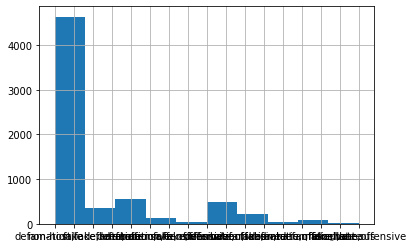

In [14]:
df['Labels Set'].hist()

In [18]:
posts = df.Post
print(posts)

0       भारतीय सेना के जवानों ने हर बार चीन की कोशिशों...
1       खुद को कॉरॉना हुआ तो अब दिल्ली के अस्पताल सभी ...
2       कंगना रनौत का ऑफिस अगर अवैध रूप से बना है। तो ...
3       महाराष्ट्र सरकार ने कंगना को सुरक्षा मिलने पर ...
4       @KanganaTeeam घटिया ओरत आ गई ओकाद पे, हिन्दू म...
                              ...                        
6546    किसानों की दुगणी आय $$ वाला डाॅयलाॅग शायद यही ...
6547                    जब सोनिया गाँधी एक बार डाँसर थी\n
6548    क्रेडिट कार्ड से लोन नहीं मिलने से नाराज छात्र...
6549    सऊदी अरब सरकार ने अरबी में भगवद्गीता रिलीज की ...
6550    एससीओ बैठक के लिए आज रूस जाएंगे राजनाथ, चीन से...
Name: Post, Length: 6551, dtype: object


In [48]:
def tokenize(Post):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    Post = " ".join(re.split("[^a-zA-Z]+", Post.lower())).strip()
    tokens = [stemmer.stem(t) for t in Post.split()]
    return tokens

def basic_tokenize(Post):
    """Same as tokenize but without the stemming"""
    Post = " ".join(re.split("[^a-zA-Z.,!?]+", Post.lower())).strip()
    return Post.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [49]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(posts).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

In [51]:
print(idf_dict)

{0: 7.3024663389438755, 1: 6.420077158745403, 2: 7.995613519503821, 3: 7.590148411395657, 4: 7.590148411395657, 5: 8.177935076297775, 6: 7.389477715933506, 7: 5.469884875195566, 8: 7.841462839676563, 9: 8.177935076297775, 10: 7.590148411395657, 11: 8.177935076297775, 12: 7.841462839676563, 13: 6.35338578424673, 14: 8.177935076297775, 15: 7.995613519503821, 16: 7.841462839676563, 17: 7.995613519503821, 18: 7.995613519503821, 19: 7.590148411395657, 20: 7.48478789573783, 21: 7.995613519503821, 22: 7.995613519503821, 23: 7.3024663389438755, 24: 7.3024663389438755, 25: 8.177935076297775, 26: 8.177935076297775, 27: 7.995613519503821, 28: 5.836129270150449, 29: 6.32163708593215, 30: 5.6129857188362395, 31: 8.177935076297775, 32: 6.95415964467566, 33: 7.389477715933506, 34: 6.0984935346179405, 35: 7.70793144705204, 36: 7.995613519503821, 37: 7.1483156591166175, 38: 7.995613519503821, 39: 7.3024663389438755, 40: 7.995613519503821, 41: 6.842934009565436, 42: 5.798388942167602, 43: 8.177935076297

In [52]:
print(idf_vals)

[7.30246634 6.42007716 7.99561352 7.59014841 7.59014841 8.17793508
 7.38947772 5.46988488 7.84146284 8.17793508 7.59014841 8.17793508
 7.84146284 6.35338578 8.17793508 7.99561352 7.84146284 7.99561352
 7.99561352 7.59014841 7.4847879  7.99561352 7.99561352 7.30246634
 7.30246634 8.17793508 8.17793508 7.99561352 5.83612927 6.32163709
 5.61298572 8.17793508 6.95415964 7.38947772 6.09849353 7.70793145
 7.99561352 7.14831566 7.99561352 7.30246634 7.99561352 6.84293401
 5.79838894 8.17793508 8.17793508 7.99561352 6.29086543 8.17793508
 6.65187877 7.99561352 6.45516848 7.59014841 7.30246634 7.70793145
 7.99561352 5.93722539 7.70793145 7.99561352 5.04244086 7.99561352
 7.99561352 7.99561352 7.99561352 7.4847879  8.17793508 8.17793508
 8.17793508 6.38617561 7.4847879  8.17793508 7.84146284 7.99561352
 8.17793508 7.84146284 7.22242363 7.70793145 7.22242363 8.17793508
 7.38947772 8.17793508 8.17793508 7.99561352 7.99561352 7.38947772
 7.84146284 7.4847879  7.99561352 8.17793508 8.17793508 7.2224

In [54]:
nltk.download('averaged_perceptron_tagger')

#Get POS tags for posts and save as a string
post_tags = []
for t in posts:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    post_tags.append(tag_str)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\TeAmp0is0N\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


In [55]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [56]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(post_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [60]:
#Now get other features
sentiment_analyzer = VS()

def count_post_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    emoji_regex = '&#[0-9]{4,6};'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    parsed_text = re.sub(emoji_regex, 'EMOJIHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'),parsed_text.count('EMOJIHERE'))

def other_features(Post):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(Post)
    
    words = preprocess(Post) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(Post)
    num_terms = len(Post.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    post_objs = count_post_objs(Post)
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                post_objs[2], post_objs[1],
                post_objs[0]]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(posts):
    feats=[]
    for t in posts:
        feats.append(other_features(t))
    return np.array(feats)

In [61]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls"]

In [62]:
feats = get_feature_array(posts)
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)
M.shape

(6551, 483)

In [63]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

In [64]:
X = pd.DataFrame(M)
y = df['Labels Set'].astype(str)

In [82]:
select = SelectFromModel(LogisticRegression(class_weight='balanced', C=0.01, penalty='l1', solver='liblinear', max_iter=100000))
X_ = select.fit_transform(X,y)

C:\Users\TeAmp0is0N\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [83]:
model = LinearSVC(class_weight='balanced', C=0.01, penalty='l2', loss='squared_hinge', multi_class='ovr', dual=False).fit(X_, y)

In [84]:
model = LogisticRegression(class_weight='balanced', penalty='l2', C=0.01, max_iter=76000).fit(X_,y)

C:\Users\TeAmp0is0N\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\TeAmp0is0N\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [85]:
y_preds = model.predict(X_)

In [86]:
report = classification_report( y, y_preds )
print(report)

                                precision    recall  f1-score   support

                    defamation       0.23      0.03      0.06       348
               defamation,fake       0.04      0.03      0.03        39
          defamation,fake,hate       0.04      0.60      0.07        10
defamation,fake,hate,offensive       0.03      0.50      0.06        10
     defamation,fake,offensive       0.08      0.07      0.08        28
               defamation,hate       0.18      0.02      0.04        84
     defamation,hate,offensive       0.05      0.12      0.07        32
          defamation,offensive       0.07      0.04      0.05        92
                          fake       0.52      0.66      0.58      1151
                     fake,hate       0.02      0.10      0.03        31
           fake,hate,offensive       0.02      0.60      0.04         5
                fake,offensive       0.07      0.06      0.07        32
                          hate       0.41      0.10      0.16  